In [1]:
import pandas as pd
import numpy as np

from scipy.spatial.distance import cdist
from scipy.stats import spearmanr

import scvelo as scv
import scanpy as sc
import anndata as an
import scvi
from scipy.stats import zscore

import matplotlib.pyplot as plt
import seaborn as sns

# Load expression

In [2]:
%%time

fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/integrated_anndata/cell_cycle/imputed.h5ad"
adata = sc.read_h5ad(fpath)
adata

CPU times: user 465 ms, sys: 3.18 s, total: 3.64 s
Wall time: 6.15 s


AnnData object with n_obs × n_vars = 6895 × 15906
    obs: 'batch', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'n_reads', 'raw_clusters', 'bbknn_clusters', 'harmony_clusters', 'cluster_str', 'barcoded_phase', 'S_score', 'G2M_score', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'nnz', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'leiden', 'cluster_phase'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_

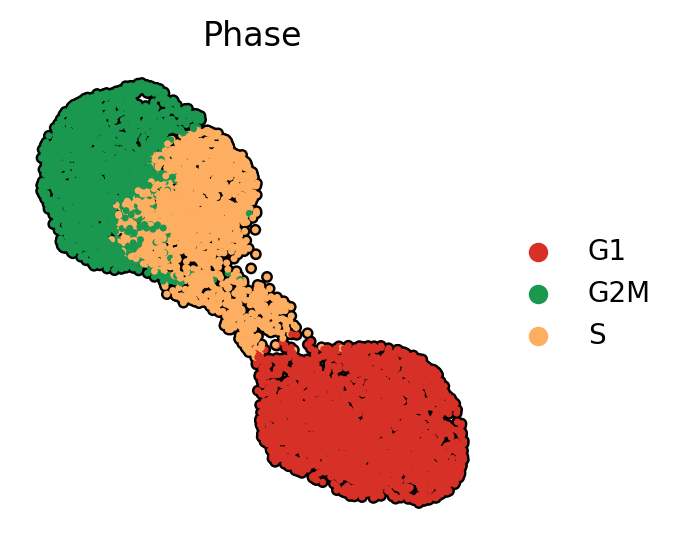

In [62]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

palette = {
    "G1": "#D73027",        
    "S": "#FDAE61",       
    "G2M": "#1A9850",    
    "unknown": "#B0B0B0", 
}
    
sc.pl.umap(
    adata,
    color='cluster_phase',
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    layer=layer,
    add_outline=True,
    outline_color=('k', 'k'),
    palette=palette,
    title='Phase',
    frameon=False,
    wspace=0.25,
)

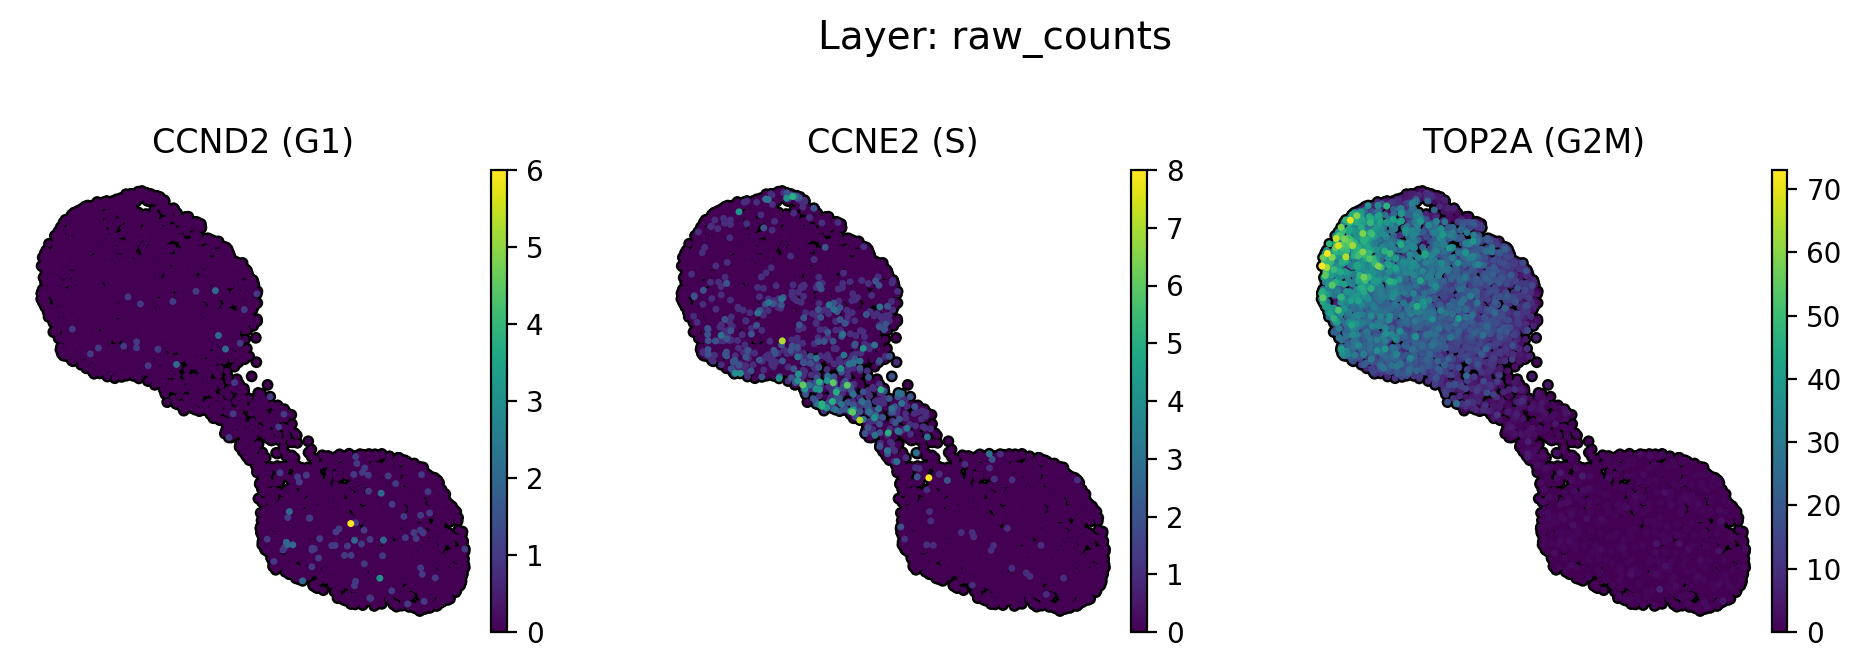

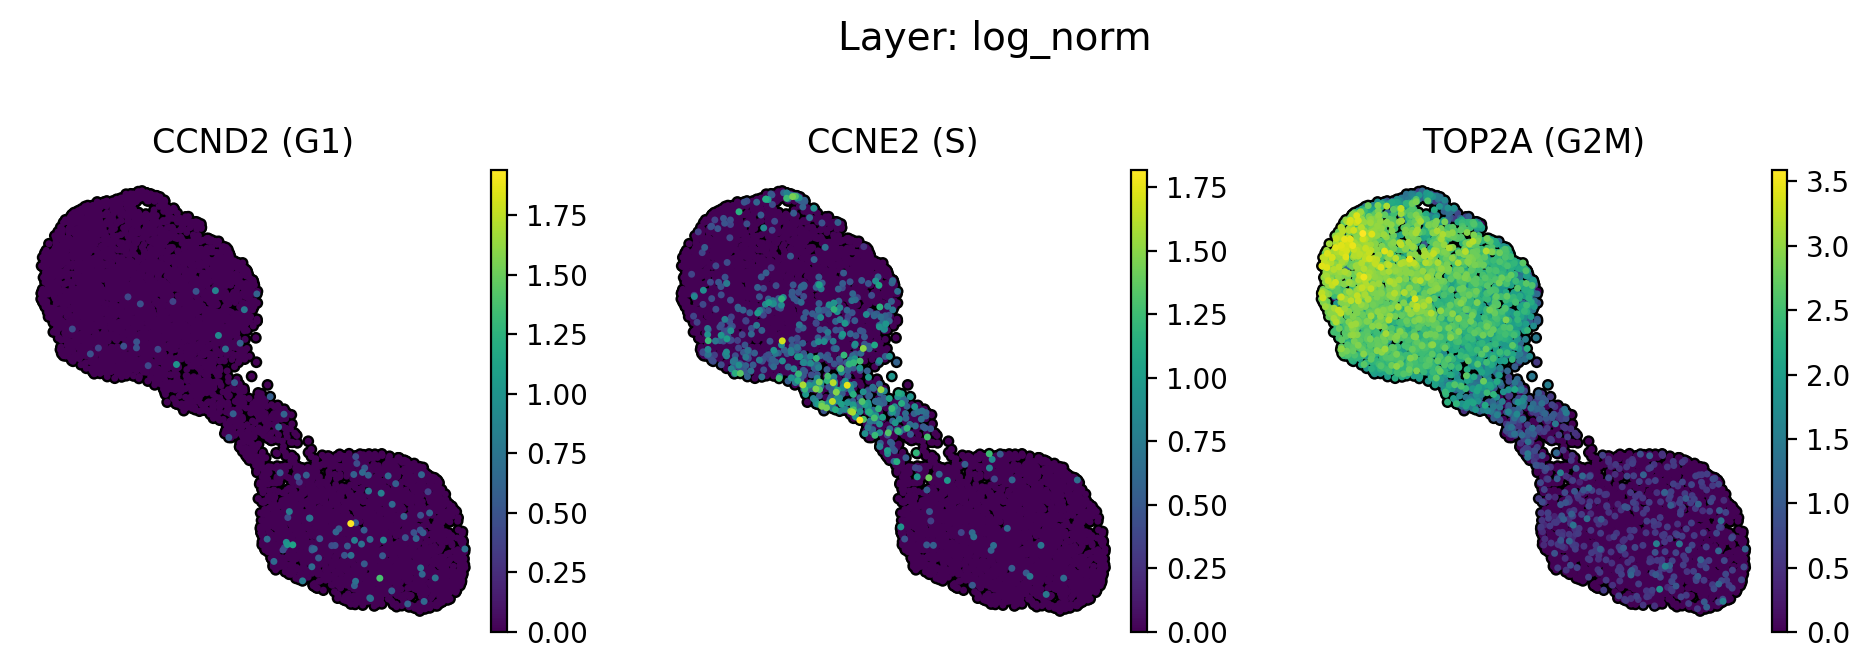

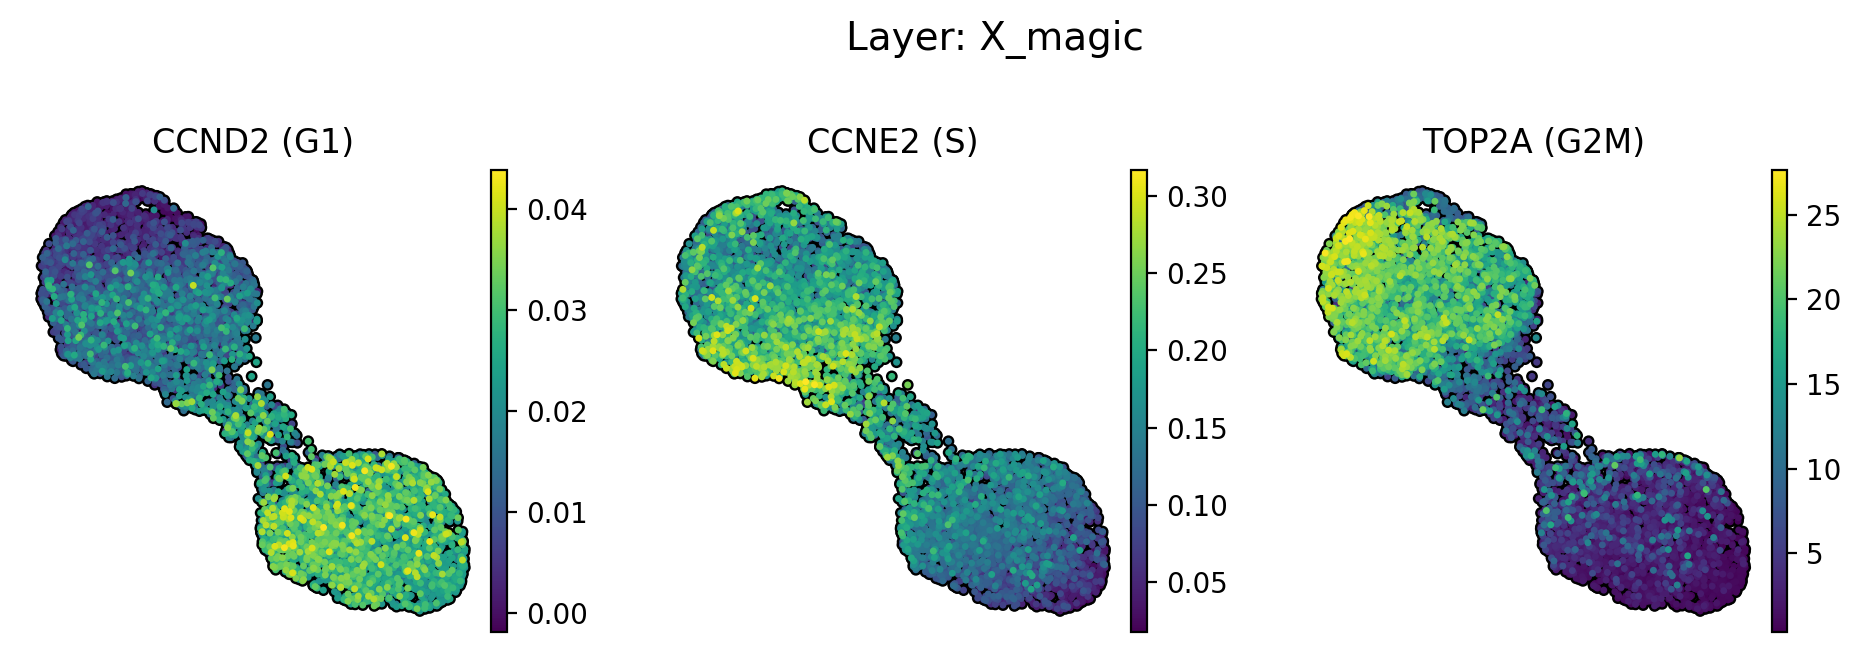

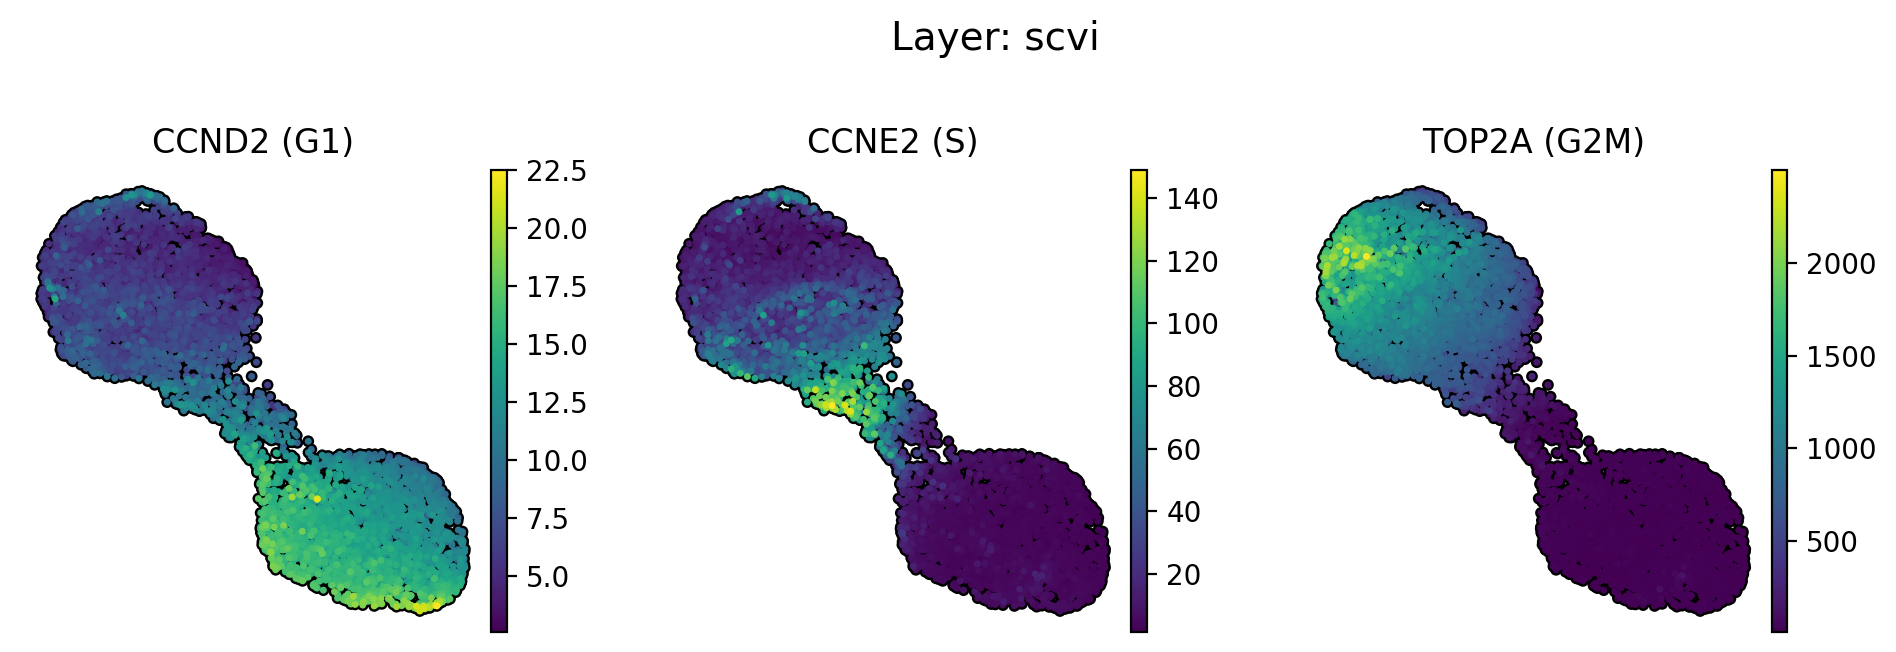

CPU times: user 3.05 s, sys: 135 ms, total: 3.19 s
Wall time: 3.19 s


In [60]:
%%time
genes = {
    "G1" : "CCND2",
    "S" : "CCNE2", 
    "G2M" : "TOP2A"  
}

titles = [f"{v} ({k})" for k, v in genes.items()]

for layer in ['raw_counts', 'log_norm',  'X_magic', 'scvi',]:


    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 3, 3
    
    axes = sc.pl.umap(
        adata,
        color=genes.values(),
        size=25,
        ncols=3,
        alpha=1,
        use_raw=False,
        layer=layer,
        add_outline=True,
        outline_color=('k', 'k'),
        title=titles,
        frameon=False,
        wspace=0.25,
        return_fig=True,   # <- important
    )
    
    axes.figure.suptitle(f"Layer: {layer}", fontsize=14, y=1.15)
    plt.show()

# Pick Root Cell

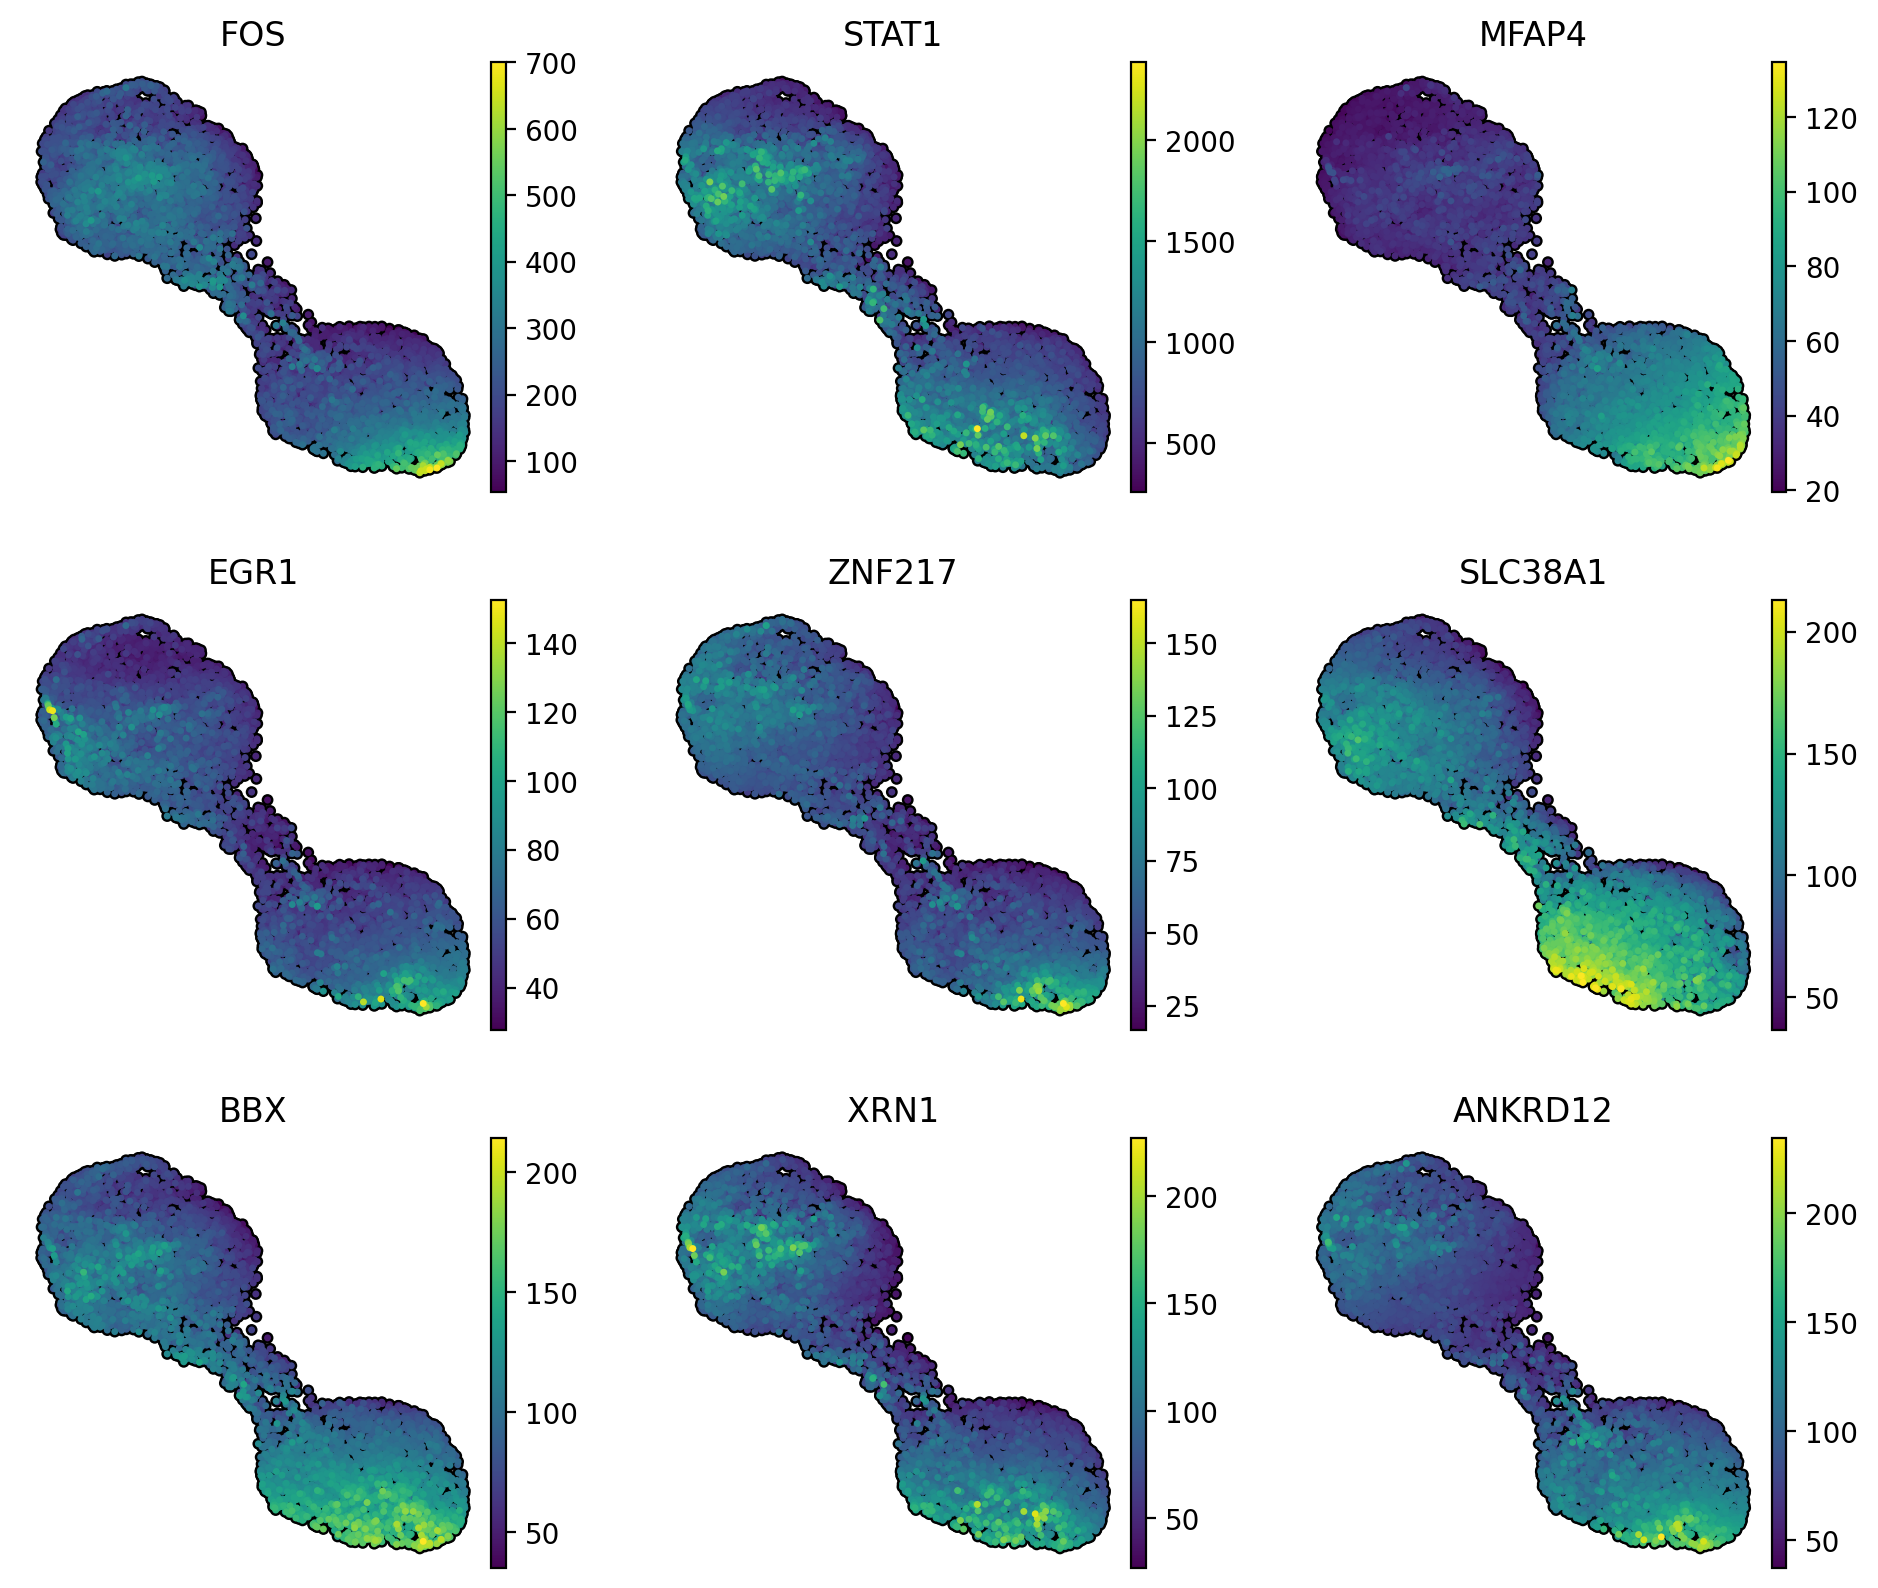

In [65]:
"""
Identify early G1 genes from: 
    M. J. Beyrouthy et al., “Identification of G1-Regulated Genes in Normally Cycling Human Cells,” PLOS ONE, vol. 3, no. 12, p. e3943, Dec. 2008

"""

genes = [
    "FOS", "STAT1", "MFAP4", "EGR1", "ZNF217",
    "SLC38A1","BBX","XRN1", "ANKRD12",
]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sc.pl.umap(
    adata,
    color=genes,
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    layer='scvi',
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    wspace=0.25,
)


      gene  mean_expr
5    STAT1  12.809405
3      FOS   2.275027
1  SLC38A1   1.592091
7      BBX   1.437478
8  ANKRD12   1.185607
2     XRN1   1.180620
0    MFAP4   0.686142
4     EGR1   0.625579
6   ZNF217   0.587460


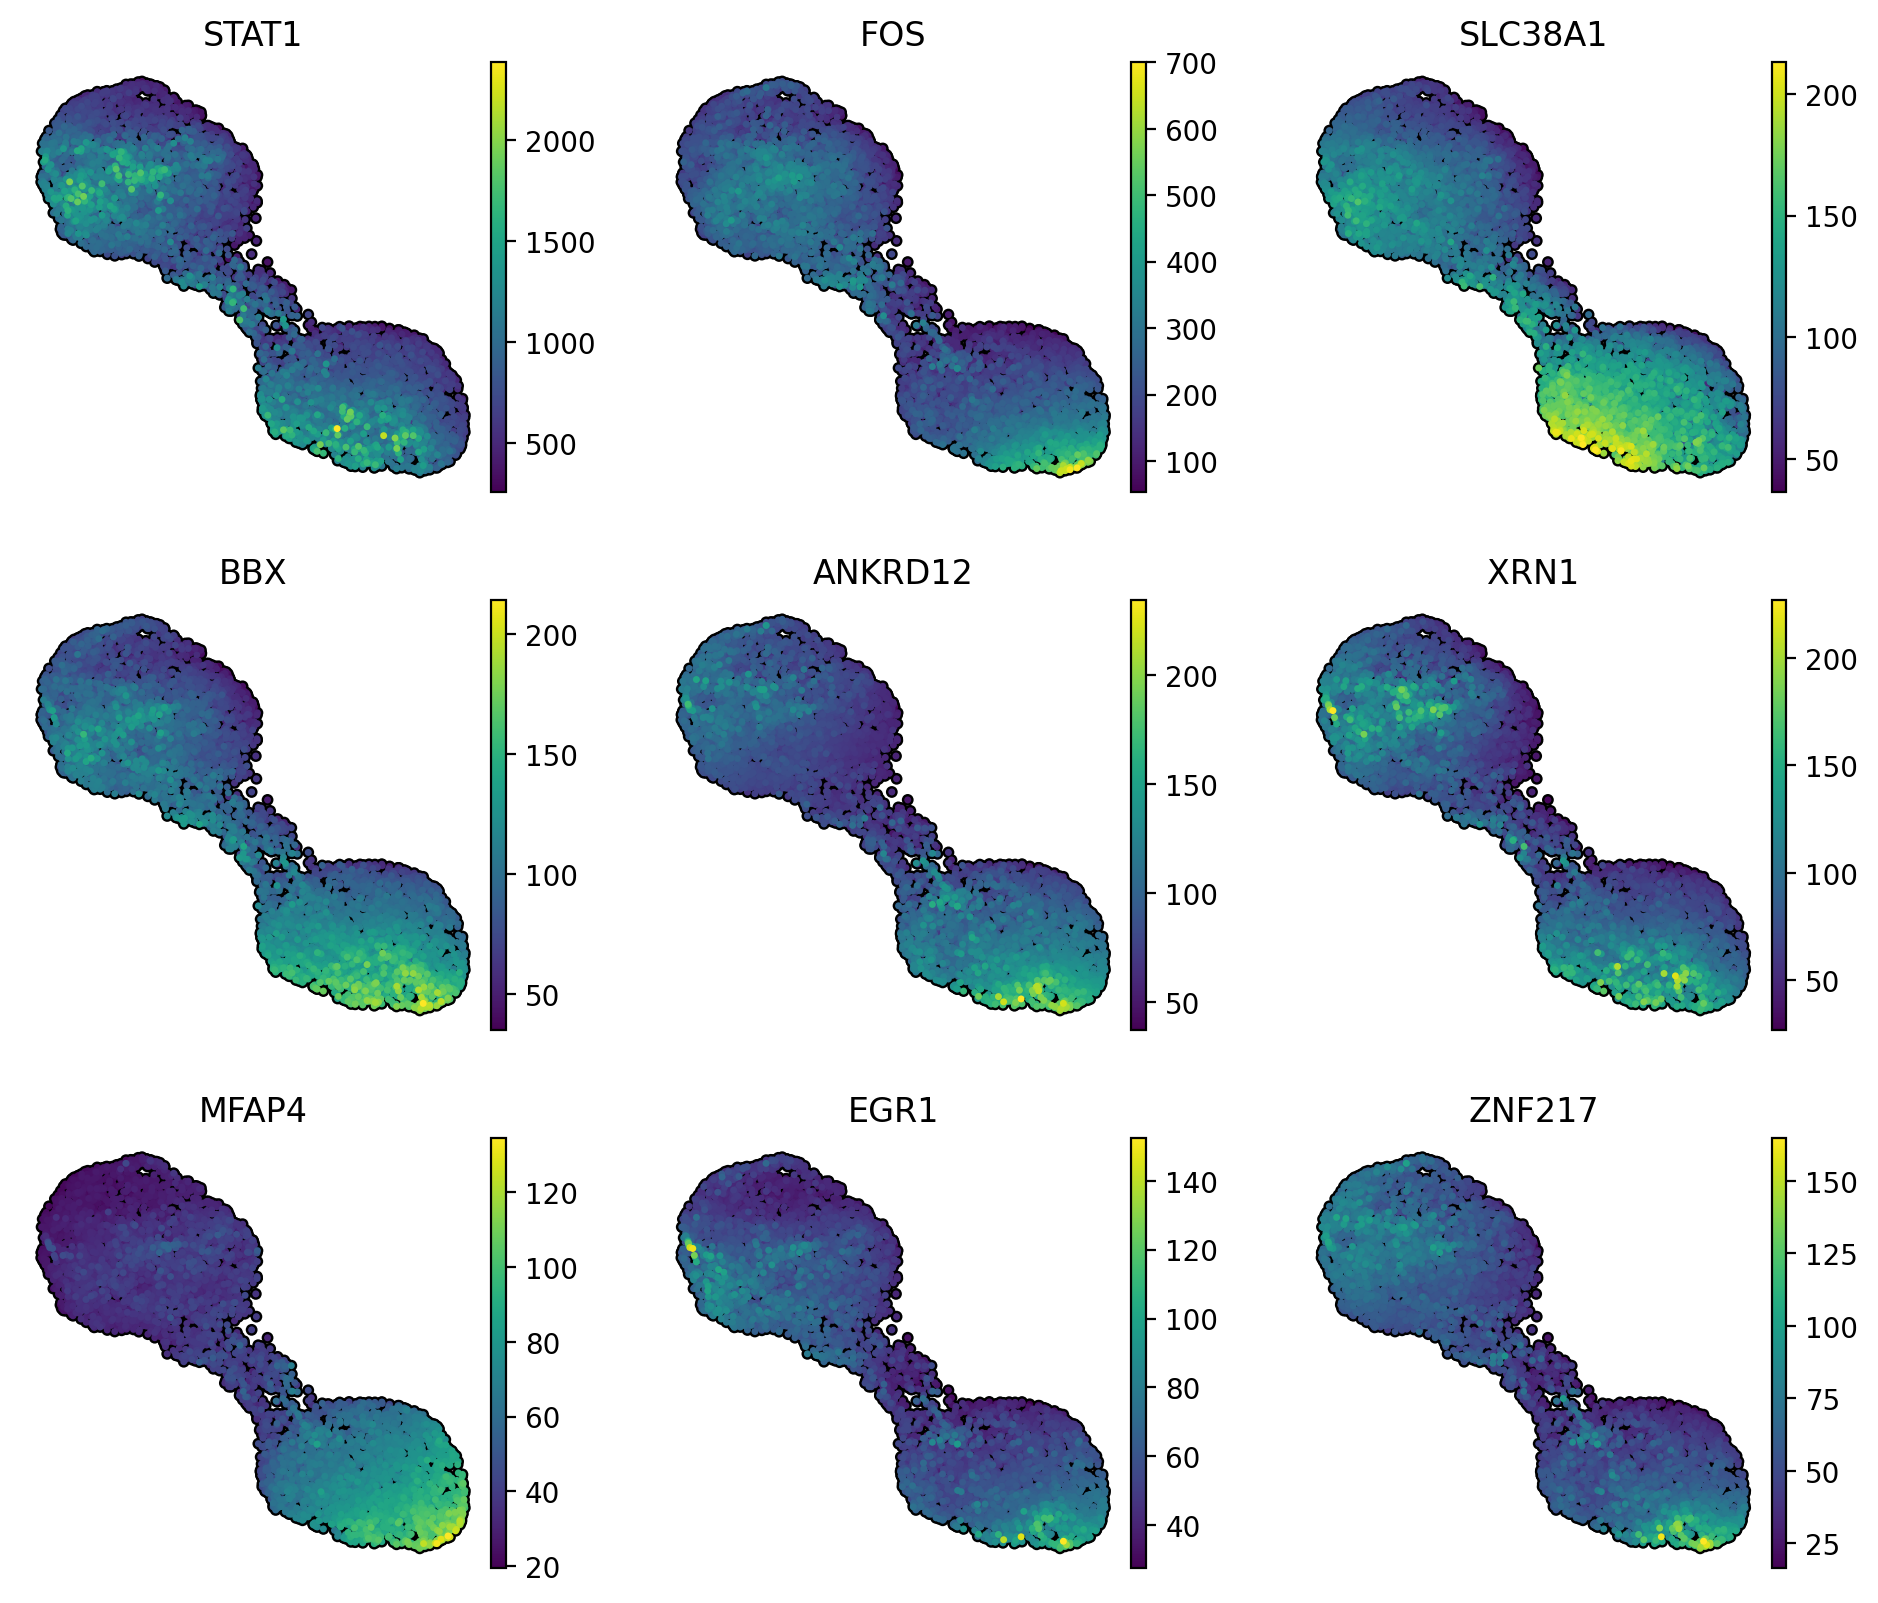

In [50]:
# genes = [
#     "FOS", "STAT1", "MFAP4", "EGR1", "ZNF217",
#      "SLC38A1","BBX","XRN1", "ANKRD12",
# ]

# # subset cells in G1 phase
# g1_mask = adata.obs["phase"] == "G1"
# adata_g1 = adata[g1_mask, :]

# # restrict to genes of interest (intersection with .var_names)
# gene_subset = list(set(genes).intersection(adata.var_names))

# # compute mean expression of each gene in G1
# mean_expr = np.asarray(adata_g1[:, gene_subset].X.mean(axis=0)).ravel()

# # make a DataFrame for easy ranking
# df_expr = pd.DataFrame({"gene": gene_subset, "mean_expr": mean_expr})

# # get top 25
# df_expr = df_expr.sort_values("mean_expr", ascending=False).head(25)
# print(df_expr)

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 3, 3


# sc.pl.umap(
#     adata,
#     color=df_expr['gene'].to_list(),
#     size=25,
#     ncols=3,
#     alpha=1,
#     use_raw=False,
#     layer='scvi',
#     add_outline=True,
#     outline_color=('k', 'k'),
#     frameon=False,
#     wspace=0.25,
# )

In [49]:
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 3, 3

# genes = {
#     "G1" : "CCND2",
#     "S" : "CCNE2", 
#     "G2M" : "TOP2A"  
# }

# titles = [f"{v} ({k})" for k, v in genes.items()]

# sc.pl.umap(
#     adata,
#     color=genes.values(),
#     size=25,
#     ncols=3,
#     alpha=1,
#     use_raw=False,
#     layer='X_magic',
#     add_outline=True,
#     outline_color=('k', 'k'),
#     title=titles,
#     frameon=False,
#     wspace=0.25,
# )

In [31]:
genes = [
    "CDC6",
    "FZR1",
    "CDT1",
    "CHEK2",
    "MYC",
    "ORC1", "ORC2", "ORC3", "ORC4", "ORC5", "ORC6",
    "CDKN2B",
    "CDKN2A",
    "CDKN2C",
    "CDKN2D",
    "RB1",
    "RBL1",
    "RBL2",
    "CDK4",
    "CDK6",
    "CCND1",
    "CCND2",
    "CCND3"
]

genes = [x for x in genes if x in adata.var_names]

adata[adata.obs['cluster_phase'] == 'G1', genes].to_df(layer='raw_counts').sum(axis=0).sort_values(ascending=False)

CCND1     7073.0
RB1       2431.0
CDK6      1929.0
CDK4      1824.0
CDKN2A    1746.0
ORC3      1073.0
CCND3      781.0
ORC2       689.0
MYC        600.0
ORC4       546.0
RBL2       317.0
CDKN2C     261.0
ORC5       246.0
CHEK2      233.0
FZR1       229.0
ORC6       200.0
CDKN2D     124.0
RBL1       121.0
CDKN2B      93.0
CCND2       86.0
CDC6        50.0
CDT1        22.0
ORC1        19.0
dtype: float64

In [ ]:
break

In [ ]:
# G1 genes
genes = [
    "CCNE1", "CCNE2", "CCND1", "CDK2", "CDK4", "CDK6",
    "SLBP", "RFC4", "POLD3"
]
genes = [x for x in genes if x in adata.var_names]
print(f"{len(genes)=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sc.pl.umap(
    adata,
    color=genes,
    palette=palette,
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    layer='scvi',
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    wspace=0.25,
)

In [ ]:
# G2/M Genes
genes = [
    "MKI67", "TOP2A", "CCNA2", "CCNB1", "CCNB2",
    "BUB1", "KIF11", "KIF23", "CENPE",
    "CDCA8", "CKS2", "TPX2", "TTK", "TROAP", "DEPDC1", "GPSM2"
]

genes = [x for x in genes if x in adata.var_names]
print(f"{len(genes)=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sc.pl.umap(
    adata,
    color=genes,
    palette=palette,
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    layer='scvi',
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    wspace=0.25,
)

From:

A. Riba et al., “Cell cycle gene regulation dynamics revealed by RNA velocity and deep-learning,” Nat Commun, vol. 13, no. 1, p. 2865, May 2022, doi: 10.1038/s41467-022-30545-8.


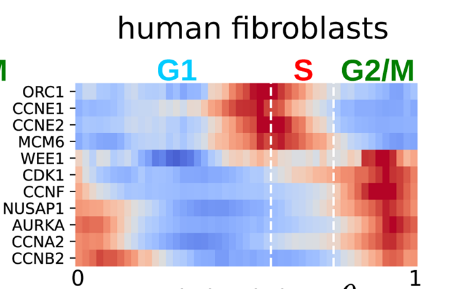

In [ ]:
genes = [
    "ORC1","CCNE1","CCNE2",
    "MCM6","WEE1","CDK1",
    "CCNF","NUSAP1","AURKA",
    "CCNA2","CCNB2"
]

genes = [x for x in genes if x in adata.var_names]
print(f"{len(genes)=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sc.pl.umap(
    adata,
    color=genes,
    palette=palette,
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    layer='scvi',
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    wspace=0.25,
)


# Early G1

Identify early G1 genes from:

M. J. Beyrouthy et al., “Identification of G1-Regulated Genes in Normally Cycling Human Cells,” PLOS ONE, vol. 3, no. 12, p. e3943, Dec. 2008, doi: 10.1371/journal.pone.0003943.


In [ ]:
genes = [
    "FOS", "STAT1", "MFAP4", "EGR1", "ZNF217",
     "SLC38A1","BBX","XRN1", "ANKRD12",
]

# subset cells in G1 phase
g1_mask = adata.obs["phase"] == "G1"
adata_g1 = adata[g1_mask, :]

# restrict to genes of interest (intersection with .var_names)
gene_subset = list(set(genes).intersection(adata.var_names))

# compute mean expression of each gene in G1
mean_expr = np.asarray(adata_g1[:, gene_subset].X.mean(axis=0)).ravel()

# make a DataFrame for easy ranking
df_expr = pd.DataFrame({"gene": gene_subset, "mean_expr": mean_expr})

# get top 25
df_expr = df_expr.sort_values("mean_expr", ascending=False).head(25)
print(df_expr)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3


sc.pl.umap(
    adata,
    color=df_expr['gene'].to_list(),
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    layer='scvi',
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    wspace=0.25,
)

In [ ]:
phase_column = 'cluster_phase' # could be cluster_phase instead

# score cells by your gene set
sc.tl.score_genes(
    adata, 
    gene_list=genes,
    score_name="early_g1_score",
    use_raw=False,
    layer='scvi',
)

# compute threshold at the 85th percentile of the scores
threshold = np.percentile(adata.obs["early_g1_score"], 85)

# print threshold and distribution summary
print("85th percentile threshold:", threshold)

adata.obs["G1_stage"] = np.where(
    adata.obs[phase_column] == "G1",                       # only assign labels in G1
    np.where(adata.obs["early_g1_score"] > threshold, "early", "late"),
    np.nan                                            # non-G1 cells
)

print(adata.obs["G1_stage"].value_counts(dropna=False))

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sc.pl.umap(
    adata,
    color=['early_g1_score', 'G1_stage'],
    cmap='plasma',
    size=25,
    ncols=2,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    wspace=0.25,
)

# GO G1 Markers

In [ ]:
fpath = "../../../hematokytos/resources/human_cell_cycle_genes.csv"
cdf = pd.read_csv(fpath) 
cdf = cdf[cdf['G1 Phase']]
print(f"{cdf.shape=}")
cdf.head()

genes = cdf['gene_name'].to_list()

genes = [x for x in genes if x in adata.var_names]
genes = ['phase'] + genes
print(f"{len(genes)=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sc.pl.umap(
    adata,
    color=genes,
    palette=palette,
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    layer='scvi',
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    wspace=0.25,
)


In [ ]:
fpath = "liu_2017_genes.csv"
cdf = pd.read_csv(fpath)
cdf = cdf[cdf['phase'] != 'G2MvsS']

alpha = 0.05
log2FoldChange = -1
cdf = cdf[cdf['padj'] <= alpha]
cdf = cdf[cdf['log2FoldChange'] <= log2FoldChange]

print(cdf['phase'].value_counts().to_string())

genes = cdf['gene_name'].unique()
genes = [x for x in genes if x in adata.var_names]
print(f"{len(genes)=}")

# score cells by your gene set
sc.tl.score_genes(
    adata, 
    gene_list=genes,
    score_name="g1_score",
    use_raw=False,
    layer='scvi',
)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sc.pl.umap(
    adata,
    color=['g1_score', 'phase'],
    cmap='plasma',
    size=25,
    ncols=2,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    wspace=0.25,
)

# Pseudotime

In [ ]:
def find_closest_cell(adata, obs_key='G1_stage', value='early', obsm_key='X_scvi'):
    """
    Find the cell closest to a median vector in PCA space.

    Parameters:
        adata (AnnData): Annotated data matrix.
        obs_key (str): Key in adata.obs indicating group
        value (str): The value for aggregation 
        obsm_key (str): Key in adata.obsm for PCA or other embedding.

    Returns:
        tuple: (cell_id (str), index (int)) of the closest G1 cell in adata.obs_names
    """
    mask = adata.obs[obs_key] == value
    emb = adata.obsm[obsm_key][mask]

    median_vec = np.mean(emb, axis=0)
    dists = cdist(emb, median_vec.reshape(1, -1)).flatten()
    closest_idx = np.argmin(dists)

    cell_id = adata.obs_names[mask][closest_idx]
    cell_index = np.where(adata.obs_names == cell_id)[0][0]

    return cell_id, cell_index

find_closest_cell(adata)

In [ ]:
%%time 
sc.pp.neighbors(adata, n_neighbors=75, use_rep='X_scvi')
sc.tl.diffmap(adata, n_comps=adata.obsm['X_scvi'].shape[1])

# choose representative cells from either G1 or G2M
cell_id, root_idx = find_closest_cell(
    adata, 
    obs_key='G1_stage', 
    value='early',
    obsm_key='X_scvi'
)

print(f"{cell_id=} {root_idx=}")

# set root and run pseudotime
adata.uns["iroot"] = root_idx
sc.tl.dpt(adata)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sc.pl.umap(
    adata, 
    color=['phase', 'dpt_pseudotime'],
    size=25,
    ncols=2,
    alpha=1,
    use_raw=False,
    na_in_legend=False,
    add_outline=True,
    outline_color=('k', 'k'),
    palette=palette,
    frameon=False,
)

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 3

sns.boxplot(
    data=adata.obs,
    x='cluster_phase',
    y='dpt_pseudotime',
    hue='cluster_phase',
    palette=palette,
    linecolor='k',
    width=0.6,
    order=['G1', 'S', 'G2M'],
    flierprops={'markersize' : 0.6, 'alpha' : 0.5}
)

plt.ylabel('Diffusion Pseudotime')
plt.xlabel('Phase')

sns.despine()

In [ ]:
%%time 
phase_lengths = {'G1' : 12, 'S' : 6,'G2M' : 4,}
lengths = pd.Series(phase_lengths)
offsets = lengths.cumsum().shift(fill_value=0).to_dict()

# copy over from embed, keep them distinct
adata.obs['dpt_pseudotime'] = embed.obs['dpt_pseudotime'].reindex(adata.obs_names)
adata.obs['dpt_order']      = embed.obs['dpt_order'].reindex(adata.obs_names)
adata.obs['phase_length'] = adata.obs['phase'].map(phase_lengths).astype(float)
adata.obs['phase_offset'] = adata.obs['phase'].map(offsets).astype(float)

def directional_rank(df):
    r = df['dpt_pseudotime'].rank(pct=True, ascending=True)
    # use dpt_order for direction; fall back to no flip if NaN
    rho, _ = spearmanr(df['dpt_pseudotime'], df['dpt_order'])
    if np.isnan(rho): 
        return r
    return 1 - r if rho < 0 else r

adata.obs['dpt_rank'] = (
    adata.obs.groupby('phase', group_keys=False).apply(directional_rank)
)

adata.obs['time_hours'] = (adata.obs['dpt_rank'] * adata.obs['phase_length']) + adata.obs['phase_offset']

# every 2 hours
adata.obs['time_bin'] = pd.cut(
    adata.obs['time_hours'],
    bins=np.arange(0, adata.obs['time_hours'].max() + 1, 1),
    labels=False,  # use integers
    include_lowest=True
)

print(adata.obs[['phase', 'time_bin', 'time_hours', 'dpt_rank']].head().to_string())

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 3

sns.boxplot(
    data=adata.obs,
    x='phase',
    y='time_hours',
    hue='phase',
    palette=palette,
    linecolor='k',
    width=0.6,
    order=['G1', 'S', 'G2M'],
    flierprops={'markersize' : 0.6, 'alpha' : 0.5}
)

plt.ylabel('Time (hrs)')
plt.xlabel('Phase')
sns.despine()

In [ ]:
layer = 'scvi'
genes = [
    'MYC', "E2F1", "RB1", "CDK6"
]

for gene in genes:
    df = pd.DataFrame({
        'time_bin' : adata.obs['time_bin'].values,
        'time_hours' : adata.obs['time_hours'].values,
        'gene' : np.ravel(adata[:, gene].layers[layer].toarray()),
    })

    df = df[df['gene'] > 0]

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 5, 2.75
    sns.scatterplot(
        data=df,
        x='time_hours', 
        y='gene', 
        c='k',
        s=4,
        alpha=0.5,
        ec='none',
    )
    sns.lineplot(
        data=df,
        x='time_bin', 
        y='gene', 
        c='r',
    )
    plt.title(gene)
    plt.ylabel(gene)
    plt.xlabel('Hours')
    plt.show()

# Select Genes

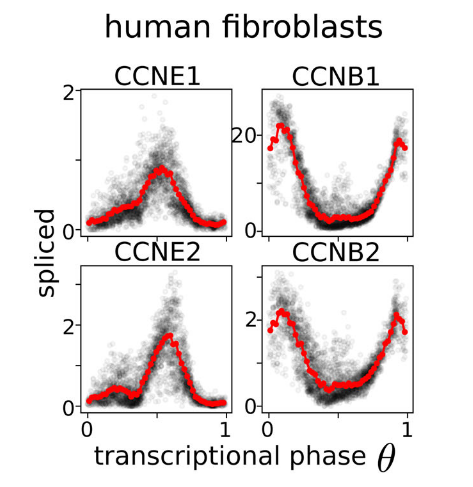

In [ ]:
genes = ["CCNE1", "CCNB1", "CCNE2", "CCNB2"]

fig, axes = plt.subplots(2, 2, figsize=(4.75, 4.75), dpi=150)
axes = axes.flatten()

for i, gene in enumerate(genes):
    y = np.ravel(adata[:, gene].layers['scvi'].toarray())
    x = adata.obs['time_hours'].values
    mask = (y > 0)
    x = x[mask]
    y = y[mask]

    # Scatter
    sns.scatterplot(
        x=x, y=y, s=3,
        ec='none',
        alpha=0.25,
        color='k',
        ax=axes[i],
    )

    # Bin and smooth
    df = pd.DataFrame({'time_hours': x, 'expr': y})
    df = df.sort_values('time_hours')
    bins = np.linspace(0, df['time_hours'].max(), 7)
    df['bin'] = np.digitize(df['time_hours'], bins)
    df_smooth = df.groupby('bin')[['time_hours', 'expr']].mean()

    axes[i].plot(df_smooth['time_hours'], df_smooth['expr'], color='red', lw=1.5, marker=".")

    axes[i].set_title(gene)
    axes[i].set_xlabel(r"time")
    axes[i].set_ylabel("counts")

plt.tight_layout()
plt.show()

In [ ]:
gene_names = [
    'POLD3', 
]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 10

fig, axes = plt.subplots(5, 5)
axes = axes.ravel()

for i, gene in enumerate(gene_names):
    y = adata[:, gene].layers['scvi'].ravel()
    y = zscore(y)
    x = adata.obs['time_hours'].values

    sns.scatterplot(
        x=x,y=y,s=3,
        ec='none',
        palette=palette,
        legend=False,
        alpha=0.5,
        hue=adata.obs[f'phase'],
        ax=axes[i]
    )
    axes[i].set_title(gene)
    axes[i].set_xlabel("")

    # degree=4 polyfit
    coeffs = np.polyfit(x, y, deg=4)
    p = np.poly1d(coeffs)
    x_fit = np.linspace(x.min(), x.max(), 200)
    y_fit = p(x_fit)

    # error estimate from residuals
    residuals = y - p(x)
    err = residuals.std()
    y_lower = y_fit - err
    y_upper = y_fit + err

    axes[i].plot(x_fit, y_fit, color="k")
    axes[i].fill_between(x_fit, y_lower, y_upper, color="k", alpha=0.2)

plt.tight_layout()

In [ ]:
break

In [ ]:
gene_names = [
    'CCNE1', 'CCND1', 'CDK2', 'CDK4', 'CDK6',
    'DEPDC1', 'POLD3', 'TPX2', 'TTK', 'GPSM2',
    'CKS2', 'TOP2A', 'CCNB1', 'CDCA8','TROAP',
    'KIF23', 'KIF11', 'MKI67', 'CENPE', 'CCNA2',
    'CCNB2', 'RFC4', 'SLBP', 'BUB1', 'CCNE2',
]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 10

fig, axes = plt.subplots(5, 5)
axes = axes.ravel()

for i, gene in enumerate(gene_names):
    y = adata[:, gene].layers['scvi'].ravel()
    y = zscore(y)
    x = adata.obs['time_hours'].values

    sns.scatterplot(
        x=x,y=y,s=3,
        ec='none',
        palette=palette,
        legend=False,
        alpha=0.5,
        hue=adata.obs[f'phase'],
        ax=axes[i]
    )
    axes[i].set_title(gene)
    axes[i].set_xlabel("")

    # degree=4 polyfit
    coeffs = np.polyfit(x, y, deg=4)
    p = np.poly1d(coeffs)
    x_fit = np.linspace(x.min(), x.max(), 200)
    y_fit = p(x_fit)

    # error estimate from residuals
    residuals = y - p(x)
    err = residuals.std()
    y_lower = y_fit - err
    y_upper = y_fit + err

    axes[i].plot(x_fit, y_fit, color="k")
    axes[i].fill_between(x_fit, y_lower, y_upper, color="k", alpha=0.2)

plt.tight_layout()

In [ ]:
break